In [15]:
import numpy as np
import torch 
import torch.nn as nn 
import torchvision 

from torch.utils.data import DataLoader, TensorDataset 
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt 

import tqdm 

import warnings

torch.manual_seed(1) 
np.random.seed(1)
warnings.filterwarnings('ignore') 

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 08: K-means e Mixture models

## Exercícios práticos

### Ler os dados 

In [2]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, 
                                                           transform=torchvision.transforms.ToTensor()) 

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                                            transform=torchvision.transforms.ToTensor())

In [3]:
def display_nine_images(dataset):
    for i, (image, label) in enumerate(dataset): 
        plt.subplot(3, 3, i + 1) 
        plt.imshow(image.permute(1, 2, 0), cmap='gray') 
        plt.title(f'Label: {label}') 
        if i >= 8: break 
    plt.suptitle(dataset.__class__.__name__) 
    # increase the space between subplots
    plt.tight_layout(pad=0.5)
    plt.show()  

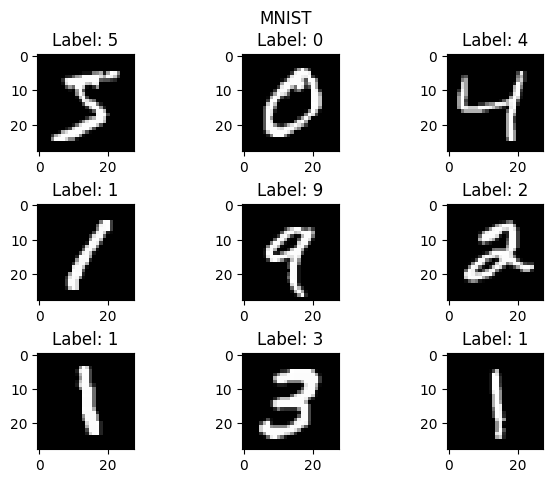

In [4]:
display_nine_images(mnist_trainset)

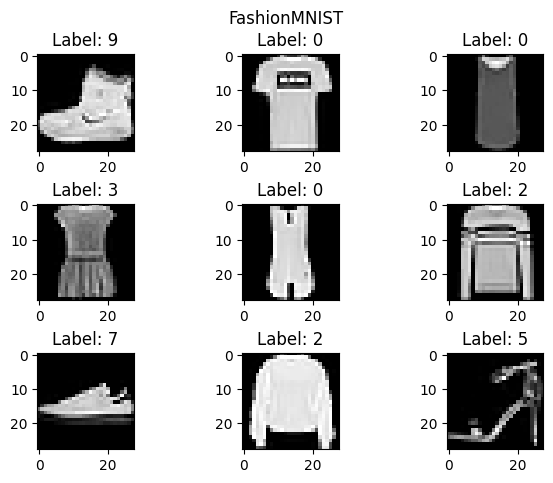

In [5]:
display_nine_images(fashion_mnist_trainset)

**1.** Implemente o algoritmo de $K$-means e aplique-o ao MNIST usando $K=10$ (o número de dígitos no banco de dados) --- inicializando os centroides aleatoriamente ou usando a estratégia do k-means++. Considere também inicializar os centróides como as médias das imagens de cada classe (é possível já que MNIST possui labels). Em geral, imagens similares são agrupadas junto? Plote exemplos de amostras em cada cluster.

**Functions to be used along this exercise:**

In [6]:
# defines a function to calculate the euclidean distance between the centroids and each data point
def EuclideanDistance(centroids, data):
    distances = np.zeros((data.shape[0], centroids.shape[0]))
    for i in range(centroids.shape[0]):
        distances[:, i] = np.linalg.norm(data - centroids[i], axis=1)
    return distances

# function to update the centroids 
def UpdateCentroids(centroids, data, labels):
    for i in range(centroids.shape[0]):
        centroids[i, :] = np.mean(data[labels == i, :], axis=0)
    return centroids

# function to k-means
def KMeans(centroids, data, k):
    # calculates the euclidean distance
    distances = EuclideanDistance(centroids, data)
    # assigns the labels to each data point
    labels = np.argmin(distances, axis=1)
    # updates the centroids
    centroids = UpdateCentroids(centroids, data, labels)

    while not np.all(np.equal(labels, np.argmin(EuclideanDistance(centroids, data), axis=1))):
        labels = np.argmin(EuclideanDistance(centroids, data), axis=1)
        centroids = UpdateCentroids(centroids, data, labels)
    return centroids, labels

In [7]:
# convert the data to an unidimensional array
train = mnist_trainset.data.numpy()
train = train.reshape(train.shape[0], -1)

In [8]:
# inicializes the centroids randomly, k
centroids = np.random.rand(10, train.shape[1])

centroids, labels = KMeans(centroids, train, 10)

common_labels = {} # dictionary to store the most common label for each cluster
labels_train = mnist_trainset.targets.numpy() # converts the labels to a numpy array

for i in range(10):
    common_labels[i] = np.argmax(np.bincount(labels_train[labels == i]))

# get the labels closest to the centroids
labels_closest_to_centroids = np.array([common_labels[label] for label in labels])

# plot the confusion matrix
confusionMatrix = confusion_matrix(labels_train, labels_closest_to_centroids)
print(confusionMatrix)

[[4248    5    7  223   44 1148  165    5   78    0]
 [   0 6692    9    5    6    6    6   10    8    0]
 [  43  714 4153  258  193  222  133   66  176    0]
 [  22  468  157 3867  168  464   33   34  918    0]
 [   7  374   33    0 3201  185  142 1889   11    0]
 [  51  397    5 1809  372 1580   72  166  969    0]
 [  55  285   64   33   65 1407 3985    1   23    0]
 [  20  597   40    5 1805   11    4 3768   15    0]
 [  29  591   43 1012  178  304   45  163 3486    0]
 [  39  346   16   83 2913   28    9 2443   72    0]]


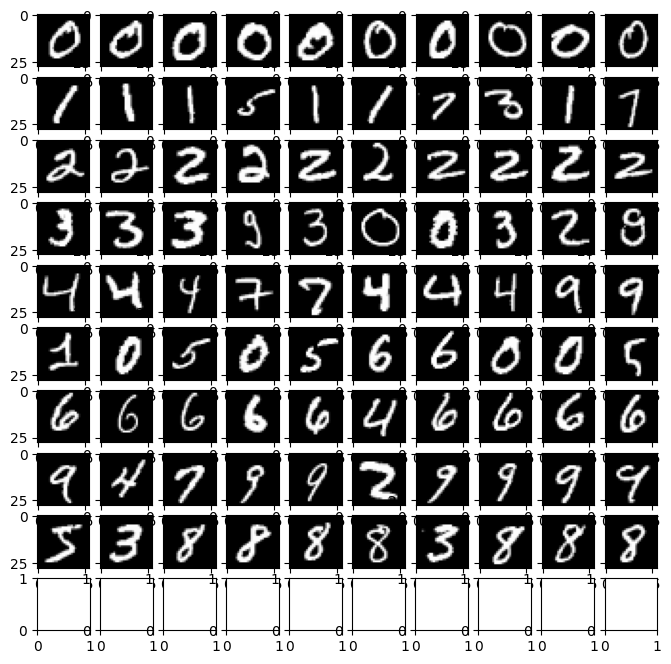

In [11]:
# plot the samples
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        if len(mnist_trainset.data[labels_closest_to_centroids == i]) >= 10:
            ax[i, j].imshow(mnist_trainset.data[labels_closest_to_centroids == i][j], cmap='gray')
plt.show()

In [12]:
# now lets do the same, but initializing the centroids with average images of each class
centroids = np.zeros((10, train.shape[1]))
for i in range(10):
    centroids[i, :] = np.mean(train[labels_train == i, :], axis=0)

centroids, labels = KMeans(centroids, train, 10)

common_labels = {} # dictionary to store the most common label for each cluster

for i in range(10):
    common_labels[i] = np.argmax(np.bincount(labels_train[labels == i]))

# get the labels closest to the centroids
labels_closest_to_centroids = np.array([common_labels[label] for label in labels])

confusionMatrix = confusion_matrix(labels_train, labels_closest_to_centroids)
print(confusionMatrix)

[[5273   19   22  164   50    0  191   37  167    0]
 [   0 6605   38   10    9    0   14   38   28    0]
 [ 105  687 4198  333  191    0  176  106  162    0]
 [ 137  397  238 4014   72    0   59  208 1006    0]
 [  10  238   16    0 2288    0  125 3153   12    0]
 [ 291  866   17 1802  205    0  136  646 1458    0]
 [ 209  437   98   30  388    0 4663    4   89    0]
 [  22  369   38    3  612    0    2 5206   13    0]
 [  64  577   55 1193  129    0   56  389 3388    0]
 [  41  169    6   93 1498    0    8 4097   37    0]]


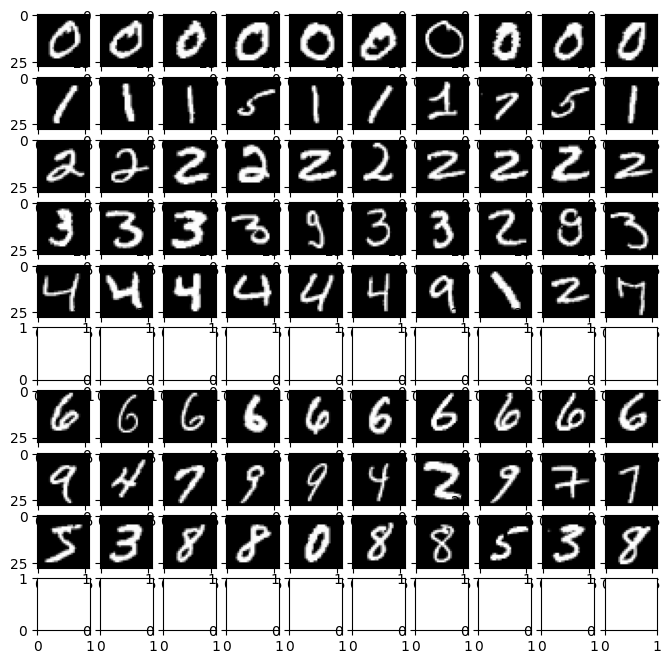

In [13]:
# plot the samples
fig, ax = plt.subplots(10, 10, figsize=(8, 8))
for i in range(10):
    for j in range(10):
        if len(mnist_trainset.data[labels_closest_to_centroids == i]) >= 10:
            ax[i, j].imshow(mnist_trainset.data[labels_closest_to_centroids == i][j], cmap='gray')
plt.show()

De fato, na maioria dos casos, imagens similares são agrupadas juntas. Mas é importante notar que há alguns casos em que ele não consegue agrupar corretamente --- no caso acima, note que 5 e 9 foram adicionados a outros clusters. Observe, na prática, que a forma randômica de inicializar os centroides forneceu resultados diferentes em relação à inicialização dos centroides como as médias das imagens de cada classe.

---

**2.** Gaussian Mixture Models (GMMs) são estimadores de densidade poderosos. Podemos utilizá-los, por exemplo, para detectar amostras "fora da distribuição de treino" (out-of-distribution, OOD) em tempo de teste, evitando possíveis previsões catastróficias. Com isso em mente, treine um MLP para classificar o MNIST. Com o MLP treinado, use um GMM para modelar as ativações da penúltima camada desse MLP (usando as ativações dos dados de treino). Agora, avalie a capacidade dessa GMM diferenciar amostras de test do MNIST e do FashionMNIST (espera-se que amostras OOD --- do Fashin MNIST--- estejam nas caudas). Teste essa estratégia com números diferentes de componente das misturas e escolha a que provê a melhor separação. Para simplificar sua vida, use a implementação de GMM do scikit-learn.

In [79]:
# lets use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get the data into a DataLoader
train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=64, shuffle=True)

In [80]:
# as in the previous exercise, lets define a class to create a neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU() 
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU() 
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x) 
        x = self.linear2(x)
        activation = self.relu2(x)
        x = self.linear3(activation)
        return x, activation

# define the model
model = NeuralNetwork(784, 128, 10).to(device)

# define the loss function
lossFunc = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [81]:
# train the model for 50 epochs
for epoch in range(50):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs, activations_train = model(images)
        loss = lossFunc(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

Epoch: 1, Loss: 2.2714
Epoch: 2, Loss: 2.2358
Epoch: 3, Loss: 2.1762
Epoch: 4, Loss: 2.0922
Epoch: 5, Loss: 1.9304
Epoch: 6, Loss: 1.5313
Epoch: 7, Loss: 1.2691
Epoch: 8, Loss: 1.2398
Epoch: 9, Loss: 0.7394
Epoch: 10, Loss: 0.7323
Epoch: 11, Loss: 0.5425
Epoch: 12, Loss: 0.9247
Epoch: 13, Loss: 0.5067
Epoch: 14, Loss: 0.5139
Epoch: 15, Loss: 0.4183
Epoch: 16, Loss: 0.5074
Epoch: 17, Loss: 0.7280
Epoch: 18, Loss: 0.9163
Epoch: 19, Loss: 0.4006
Epoch: 20, Loss: 0.5812
Epoch: 21, Loss: 0.3084
Epoch: 22, Loss: 0.4379
Epoch: 23, Loss: 0.1538
Epoch: 24, Loss: 0.3064
Epoch: 25, Loss: 0.4152
Epoch: 26, Loss: 0.6181
Epoch: 27, Loss: 0.1109
Epoch: 28, Loss: 0.4537
Epoch: 29, Loss: 0.2117
Epoch: 30, Loss: 0.2195
Epoch: 31, Loss: 0.2578
Epoch: 32, Loss: 0.4115
Epoch: 33, Loss: 0.3884
Epoch: 34, Loss: 0.4368
Epoch: 35, Loss: 0.2554
Epoch: 36, Loss: 0.4703
Epoch: 37, Loss: 0.2629
Epoch: 38, Loss: 0.2094
Epoch: 39, Loss: 0.3941
Epoch: 40, Loss: 0.4085
Epoch: 41, Loss: 0.3762
Epoch: 42, Loss: 0.2655
E

In [82]:
# define a gaussian mixture model
gmm = GaussianMixture(n_components=5)
activations_train = np.reshape(activations_train.detach().numpy()[-1], (-1,1))
gmm.fit(activations_train)

# define the threshold
threshold = np.min(gmm.score_samples(activations_train))

# test the capacity of the model to differentiate between the classes
n_ood = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs, activations_test = model(images)
        activations_test = np.reshape(activations_test.detach().numpy()[-1], (-1,1))
        scores = gmm.score_samples(activations_test)
        if (scores < threshold).any():
            n_ood += 1
        correct += outputs.argmax(1).eq(labels).sum().item()

print(f'Accuracy: {correct / len(test_loader):.2f}')
print(f'Out of distribution: {n_ood}')

Accuracy: 58.43
Out of distribution: 92


In [83]:
concatFashionMNIST = torch.utils.data.ConcatDataset([mnist_trainset, fashion_mnist_trainset])
concatTest = DataLoader(concatFashionMNIST, batch_size=64, shuffle=True)

In [84]:
# test the capacity of the model to differentiate between the classes
n_ood = 0
correct = 0
with torch.no_grad():
    for images, labels in concatTest:
        images = images.to(device)
        labels = labels.to(device)
        outputs, activations_test = model(images)
        activations_test = np.reshape(activations_test.detach().numpy()[-1], (-1,1))
        scores = gmm.score_samples(activations_test)
        # if the score is below the threshold, we consider it out of distribution
        if (scores < threshold).any():
            n_ood += 1
        correct += outputs.argmax(1).eq(labels).sum().item()

print(f'Accuracy: {correct / len(concatTest):.2f}')
print(f'Out of distribution: {n_ood}')

Accuracy: 32.58
Out of distribution: 1146


In [85]:
# lets test for different n_components
infoComponents = {}

for i in range(1, 15):
    print(f'n_components: {i}')
    gmm = GaussianMixture(n_components=i)
    gmm.fit(activations_train)
    
    threshold = np.min(gmm.score_samples(activations_train))
    print(f'threshold: {threshold}')
    n_ood = 0
    correct = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, activations_test = model(images)
            activations_test = np.reshape(activations_test.detach().numpy()[-1], (-1,1))
            scores = gmm.score_samples(activations_test)
            if (scores < threshold).any():
                n_ood += 1
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    
    infoComponents[i] = n_ood

    print(f'Accuracy: {correct / len(test_loader):.4f}')
    print(f'Out of distribution: {n_ood} \n')

n_components: 1
threshold: -6.621175847815514
Accuracy: 58.4331
Out of distribution: 96 

n_components: 2
threshold: -5.326394662585789
Accuracy: 58.4331
Out of distribution: 93 

n_components: 3
threshold: -5.13916272815438
Accuracy: 58.4331
Out of distribution: 80 

n_components: 4
threshold: -5.090443344122725
Accuracy: 58.4331
Out of distribution: 91 

n_components: 5
threshold: -5.117227976541628
Accuracy: 58.4331
Out of distribution: 96 

n_components: 6
threshold: -5.124883237179807
Accuracy: 58.4331
Out of distribution: 84 

n_components: 7
threshold: -4.748038184175295
Accuracy: 58.4331
Out of distribution: 88 

n_components: 8
threshold: -3.3020348967573594
Accuracy: 58.4331
Out of distribution: 156 

n_components: 9
threshold: -3.393464641521031
Accuracy: 58.4331
Out of distribution: 157 

n_components: 10
threshold: -3.29332449402319
Accuracy: 58.4331
Out of distribution: 157 

n_components: 11
threshold: -3.0352841656026466
Accuracy: 58.4331
Out of distribution: 157 

n_co

In [86]:
# lets find the one which separates the best when concatenating MNIST and FashionMNIST
for i in infoComponents.keys():
    print(f'n_components: {i}')
    gmm = GaussianMixture(n_components=i)
    gmm.fit(activations_train)

    # define the threshold
    threshold = np.min(gmm.score_samples(activations_train))

    # test the capacity of the model to differentiate between the classes
    n_ood = 0
    correct = 0
    with torch.no_grad():
        for images, labels in concatTest:
            images = images.to(device)
            labels = labels.to(device)
            outputs, activations_test = model(images)
            activations_test = np.reshape(activations_test.detach().numpy()[-1], (-1,1))
            scores = gmm.score_samples(activations_test)
            # if the score is below the threshold, we consider it out of distribution
            if (scores < threshold).any():
                n_ood += 1
            correct += outputs.argmax(1).eq(labels).sum().item()

    print(f'Accuracy: {correct / len(concatTest):.2f}')
    print(f'Out of distribution: {n_ood} \n')

n_components: 1
Accuracy: 32.58
Out of distribution: 1173 

n_components: 2
Accuracy: 32.58
Out of distribution: 1146 

n_components: 3
Accuracy: 32.58
Out of distribution: 1159 

n_components: 4
Accuracy: 32.58
Out of distribution: 1144 

n_components: 5
Accuracy: 32.58
Out of distribution: 1149 

n_components: 6
Accuracy: 32.58
Out of distribution: 1146 

n_components: 7
Accuracy: 32.58
Out of distribution: 1779 

n_components: 8
Accuracy: 32.58
Out of distribution: 1789 

n_components: 9
Accuracy: 32.58
Out of distribution: 1788 

n_components: 10
Accuracy: 32.58
Out of distribution: 1868 

n_components: 11
Accuracy: 32.58
Out of distribution: 1870 

n_components: 12
Accuracy: 32.58
Out of distribution: 1869 

n_components: 13
Accuracy: 32.58
Out of distribution: 1873 

n_components: 14
Accuracy: 32.58
Out of distribution: 1873 



Quando utilizamos `n_components = 14` ou `n_components = 14`, obtemos os maiores números de out of distribution, provendo a melhor separação.

---
## **Exercício de "papel e caneta"**

**1.** Como vimos anteriormente, a função custo para $k$-means é:
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \| x - \mu_i \|_2^2,
\end{equation}
a qual otimizamos atualizando os clusters e seus respectivos centróides de maneira alternada. Suponha, no entanto, que nosso banco de dados contém entradas faltantes, i.e., existe algum vetor $x=[x_1, \ldots, x_D]$ para o qual apenas as entradas $x_o \forall o(x) \in O(x) \subseteq \{1,\ldots,D\}$ foram observadas. Deixe, similarmente, que $M(x)$ denote o conjunto de índices faltantes em $x$. Existem várias maneiras de contornar esse problema. A mais animalesca (e que descarta menos informação) é jogar fora amostras com entradas faltantes. Pode-se também pré-processar o banco de dados para preencher os valores faltantes. Uma terceira opção é codificar nossa incerteza sobre $x_{M(x)}$ como uma distribuição e propagar essa incerteza pela nossa função custo. Caso não saibamos muito sobre esses valores faltantes, por exemplo, podemos atribuir uma Gaussiana com média zero e variância $c>0$ para cada $x_m \forall m \in M(x)$. Nesse caso, nossa função custo se transforma em: 
\begin{equation}
    \sum_{i=1\ldots K} \sum_{x \in C_i} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)}\big[\| x - \mu_i \|_2^2\big],
\end{equation}

Derive algoritmo para otimizar a função acima --- de maneira similar à que derivamos o $k$-means. Comente como seu algoritmo difere do $K$-means original.



#### **Resposta**

A derivação do $k$-means envolve uma otimização utilizando o algoritmo de Expectation-Maximization (EM). Na etapa E, calculamos a esperança da função de verossimilhança utilizando os parâmetros atuais. Na etapa M, maximizamos a função de verossimilhança esperada em relação aos parâmetros. O algoritmo EM é iterado até que a convergência seja alcançada.

No primeiro passo, calculamos a esperança da distância euclidiana entre os pontos de dados e os centróides. Precisamos, de alguma forma, indicar qual cluster minimiza a distância de cada ponto. Para isso, usamos uma variável indicadora $r_{nk}$, que é igual a 1 se o ponto $x_n$ pertence ao cluster $k$ e 0 caso contrário. A função de verossimilhança esperada é dada por:

$$
\begin{equation}
    \sum_{n=1}^N \sum_{k=1}^K r_{nk} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)} \| x_n - \mu_k \|_2^2
\end{equation}
$$

Já no passo de atualização dos parâmetros, maximizamos a função de verossimilhança esperada em relação aos parâmetros. Para isso, derivamos a função em relação a $\mu_k$ e igualamos a zero. Isso nos dá:

$$
\dfrac{\partial}{\partial \mu_k} \sum_{n=1}^N \sum_{k=1}^K r_{nk} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)} \| x_n - \mu_k \|_2^2 = 0 
$$

$$
\Rightarrow 2 \times \sum_{n=1}^N r_{nk} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)} (\mu_k - x_n) = 0 
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \mu_k = \sum_{n=1}^N r_{nk} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)} x_n 
$$

$$
\Rightarrow \mu_k = \dfrac{\sum_{n=1}^N r_{nk} \mathbb{E}_{x_{M(x)} \sim N\left(0, c I_{|M(x)|}\right)} x_n}{\sum_{n=1}^N r_{nk}}
$$

De forma geral, o passo a passo é definir os centróides iniciais, calcule a distância euclidiana entre os pontos de dados e os centróides, atribua os pontos de dados ao cluster mais próximo, calcule os novos centróides, repita até que os centróides não se movam mais. O processo é bastante similar ao $k$-means original, com a diferença de que, no passo de atualização dos parâmetros, precisamos calcular a esperança da distância euclidiana entre os pontos de dados e os centróides, já que não temos acesso aos valores faltantes.

---

**2.** Na aula, motivamos o uso de _Gaussian Mixture Models_ (GMMs) e discutimos como estimar seus parâmetros via máxima verossimilhança. Mais especificamente, começamos a derivar um algoritmo de _coordinate ascent_ para maximizar a verossimilhança. Siga os passos da Seção 9.2 do _Pattern Recognition and Machine Learning_ (C. Bishop) e mostre a derivação passo-a-passo (boa parte está omitida no livro) do algoritmo.

#### **Resposta**

Comece com uma distribuição de mistura Gaussiana:

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

Nosso objetivo é encontrar os parâmetros $\boldsymbol{\pi}$, $\boldsymbol{\mu}$ e $\boldsymbol{\Sigma}$ que maximizam a verossimilhança dos dados. A verossimilhança é dada por:

$$
p(\mathbf{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$

A log-verossimilhança é dada por:

$$
\log p(\mathbf{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N \log \left\{ \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right\}
$$

Vamos chamar a log-verossimilhança de $\mathcal{L}(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})$.

Precisamos definir a responsabilidade $r_{nk}$ que o componente $k$ assume pelo ponto de dados $x_n$. A responsabilidade é dada por:

$$
r_{nk} = \dfrac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
$$

Naturalmente, para maximizar a verossimilhança, precisamos derivar $\mathcal{L}$ em relação a cada um dos parâmetros e igualar a zero. No caso de $\boldsymbol{\mu}_k$,considere:

$$
\dfrac{\partial \mathcal{L}}{\partial \boldsymbol{\mu}_k} = \sum_{n=1}^N \dfrac{\partial}{\partial \boldsymbol{\mu}_k} \log \left\{ \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j) \right\} = 0
$$

$$
\Rightarrow \sum_{n=1}^N \dfrac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \boldsymbol{\mu}_k) = 0
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \boldsymbol{\mu}_k) = 0
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \boldsymbol{\Sigma}_k^{-1} \mathbf{x}_n = \sum_{n=1}^N r_{nk} \boldsymbol{\Sigma}_k^{-1} \boldsymbol{\mu}_k
$$

$$
\Rightarrow \boldsymbol{\mu}_k = \dfrac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{\sum_{n=1}^N r_{nk}}
$$

Agora, vamos derivar em relação a $\boldsymbol{\Sigma}_k$:

$$
\dfrac{\partial \mathcal{L}}{\partial \boldsymbol{\Sigma}_k} = \sum_{n=1}^N \dfrac{\partial}{\partial \boldsymbol{\Sigma}_k} \log \left\{ \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j) \right\} = 0
$$

$$
\Rightarrow \sum_{n=1}^N \dfrac{\pi_k \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)} \left\{ -\dfrac{1}{2} \boldsymbol{\Sigma}_k^{-1} + \dfrac{1}{2} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} \right\} = 0
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \left\{ -\dfrac{1}{2} \boldsymbol{\Sigma}_k^{-1} + \dfrac{1}{2} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1} \right\} = 0
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \boldsymbol{\Sigma}_k^{-1} = \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T \boldsymbol{\Sigma}_k^{-1}
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} \boldsymbol{\Sigma}_k^{-1} = \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T
$$

$$
\Rightarrow \boldsymbol{\Sigma}_k = \dfrac{\sum_{n=1}^N r_{nk} (\mathbf{x}_n - \boldsymbol{\mu}_k) (\mathbf{x}_n - \boldsymbol{\mu}_k)^T}{\sum_{n=1}^N r_{nk}}
$$

Finalmente, vamos derivar em relação a $\pi_k$:

$$
\dfrac{\partial \mathcal{L}}{\partial \pi_k} = \sum_{n=1}^N \dfrac{\partial}{\partial \pi_k} \log \left\{ \sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j) \right\} = 0
$$

$$
\Rightarrow \sum_{n=1}^N \dfrac{\mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\mathbf{x}_n | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)} = 0
$$

$$
\Rightarrow \sum_{n=1}^N r_{nk} = 0
$$

$$
\Rightarrow \pi_k = \dfrac{\sum_{n=1}^N r_{nk}}{N}
$$